In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bering = pd.read_excel(filepath, sheet_name='Bering-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Bering)
fp.date_time(Bering)

,Extent,Date
0,320266.650,1979-01-01
1,541778.338,1979-02-01
2,638262.988,1979-03-01
3,423025.159,1979-04-01
4,215587.216,1979-05-01
...,...,...
488,317377.493,2023-05-01
489,39601.476,2023-06-01
490,16935.702,2023-07-01
491,1305.744,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bering['Extent'] = scaler.fit_transform(Bering['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 5
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bering['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((477, 12, 1), (477,))

In [8]:
X_train, y_train = X[:384], y[:384]
X_val, y_val = X[384:432], y[384:432]
X_test, y_test = X[432:], y[432:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bering_model_LT5/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
48/48 [==============================] - 16s 247ms/step - loss: 0.1532 - root_mean_squared_error: 0.3914 - val_loss: 0.0409 - val_root_mean_squared_error: 0.2023
Epoch 2/50
48/48 [==============================] - 1s 17ms/step - loss: 0.0957 - root_mean_squared_error: 0.3093 - val_loss: 0.0464 - val_root_mean_squared_error: 0.2153
Epoch 3/50
48/48 [==============================] - 10s 205ms/step - loss: 0.0820 - root_mean_squared_error: 0.2863 - val_loss: 0.0396 - val_root_mean_squared_error: 0.1990
Epoch 4/50
48/48 [==============================] - 1s 18ms/step - loss: 0.0817 - root_mean_squared_error: 0.2859 - val_loss: 0.0411 - val_root_mean_squared_error: 0.2027
Epoch 5/50
48/48 [==============================] - 1s 17ms/step - loss: 0.0786 - root_mean_squared_error: 0.2804 - val_loss: 0.0403 - val_root_mean_squared_error: 0.2007
Epoch 6/50
48/48 [==============================] - 1s 16ms/step - loss: 0.0757 - root_mean_squared_error: 0.2752 - val_loss: 0.0403 - val_ro

Epoch 36/50
48/48 [==============================] - 1s 21ms/step - loss: 0.0133 - root_mean_squared_error: 0.1151 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1341
Epoch 37/50
48/48 [==============================] - 1s 17ms/step - loss: 0.0129 - root_mean_squared_error: 0.1134 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1307
Epoch 38/50
48/48 [==============================] - 1s 17ms/step - loss: 0.0134 - root_mean_squared_error: 0.1158 - val_loss: 0.0215 - val_root_mean_squared_error: 0.1467
Epoch 39/50
48/48 [==============================] - 1s 20ms/step - loss: 0.0142 - root_mean_squared_error: 0.1192 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1278
Epoch 40/50
48/48 [==============================] - 1s 17ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1495
Epoch 41/50
48/48 [==============================] - 1s 21ms/step - loss: 0.0136 - root_mean_squared_error: 0.1168 - val_loss: 0.0195 - val_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

2.815952523549398 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

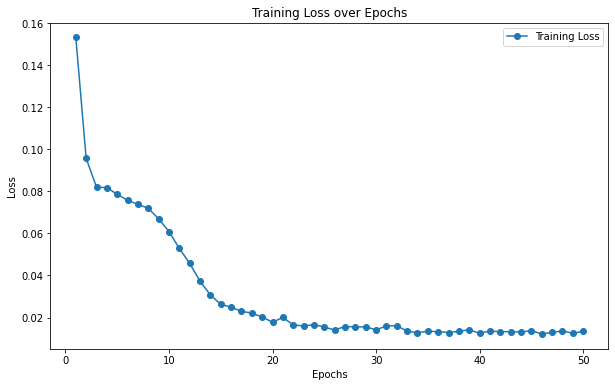

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

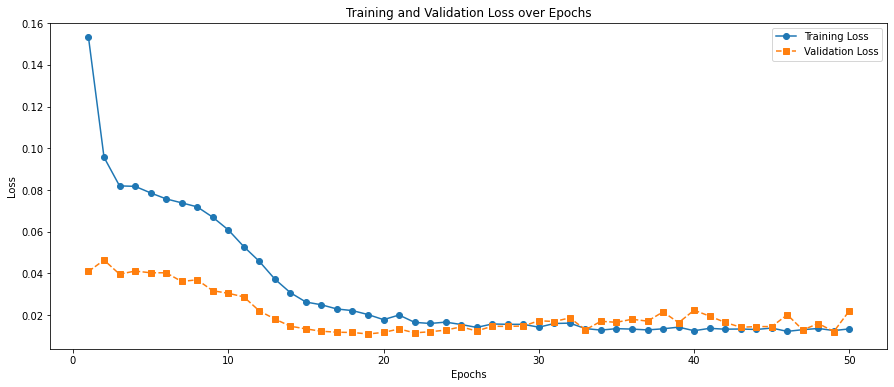

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bering_model_LT5/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 0s/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.1312909834878902
MAE : 0.0954078140038486


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,117881.304688,11293.282
1,199631.296875,49957.406
2,252698.453125,151973.751
3,294433.406250,466524.938
4,313385.656250,708542.184
5,305844.437500,652598.000
6,247976.109375,414216.785
7,118336.734375,236263.303
8,43977.871094,43422.368
9,38016.726562,2161.744


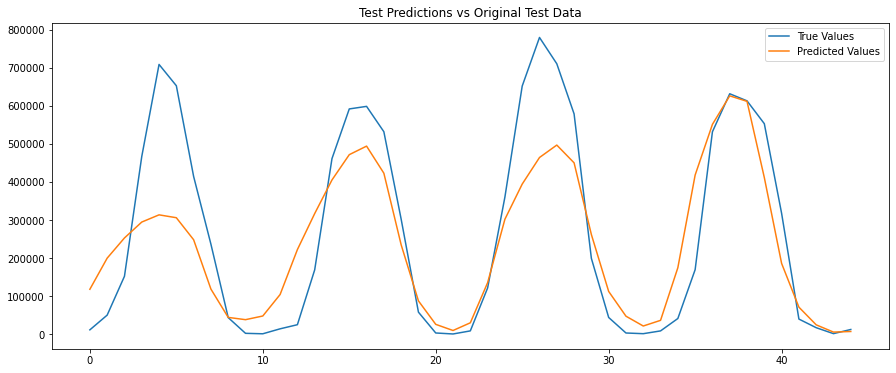

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

15/15 [==============================] - 0s 12ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

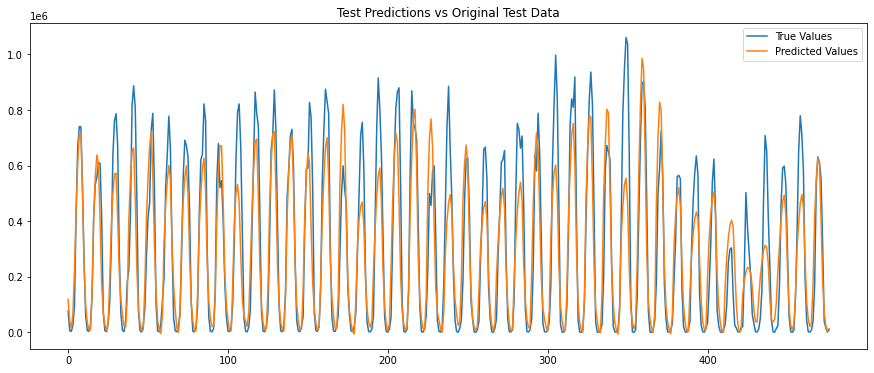

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()